# 전국 전기차 충전소 공공데이터 보기좋게 
# 정제하고 지도에 잘 시각화

In [37]:
import platform

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system()=='Darwin':
    rc('font', family='AppleGothic')
elif platform.system()=='Windows':
    path="C:/Windows/Fonts/malgun.ttf"  
    font_name=font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')
# 윈도우나 맥os 에서 matplotlib 에서 한글사용하는 코드

import pandas as pd

import seaborn as sns

import numpy as np

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import folium 
import base64
import json

In [24]:
#데이터 불러옴
el=pd.read_csv('../data/전국전기차충전소표준데이터.csv',engine='python')
el.head()   # 컬럼 0~20 까지 있음

충전소명 충전소위치상세 설치시도명   휴점일 이용가능시작시각 이용가능종료시각 완속충전가능여부 급속충전가능여부 급속충전타입구분  \
0   홈플러스 시화점  내부 주차장   경기도  연중무휴    10:00    23:00        N        Y      NaN   
1    시흥상공휴게소  외부 주차장   경기도  연중무휴    00:00    23:59        N        Y      NaN   
2      물왕영업소  외부 주차장   경기도  연중무휴    00:00    23:59        N        Y      NaN   
3     갯골생태공원  외부 주차장   경기도  연중무휴    00:00    23:59        N        Y      NaN   
4  정왕2동 주민센터  외부 주차장   경기도  연중무휴    00:00    23:59        Y        N      NaN   

   완속충전기대수  ...  주차료부과여부                          소재지도로명주소  \
0      NaN  ...        N  경기도 시흥시 희망공원로 269  지상주차장 1층 A0구역   
1      NaN  ...        N                       경기도 시흥시 조남동   
2      NaN  ...        N                  경기도 시흥시 금이진말길 34   
3      NaN  ...        Y                               NaN   
4      NaN  ...        N    경기도 시흥시 정왕대로 122(정왕동) 정왕2동주민센터   

                                  소재지지번주소     관리업체명 관리업체전화번호         위도  \
0                      경기도 시흥시 정왕동 2166-4  경기도 시흥시청      NaN  37.345208   
1                                     NaN  경기도 시흥시청      NaN  37.383496   
2                                     NaN  경기도 시흥시청      NaN  37.391933   
3  경기도 시흥시 장곡동 724-32  오른쪽 주차장 입구 오른쪽 끝부지  경기도 시흥시청      NaN  37.389792   
4                                     NaN  경기도 시흥시청      NaN  37.351037   

           경도     데이터기준일자   제공기관코드    제공기관명  
0  126.725055  2019-05-23  4010000  경기도 시흥시  
1  126.854432  2019-05-23  4010000  경기도 시흥시  
2  126.828932  2019-05-23  4010000  경기도 시흥시  
3  126.780772  2019-05-23  4010000  경기도 시흥시  
4  126.728725  2019-05-23  4010000  경기도 시흥시  

[5 rows x 21 columns]

In [25]:
# 도가 안 써저있는 행이 하나있어 도를 붙여줌 
el['소재지도로명주소'].loc[el['소재지도로명주소'] == "구좌읍 해맞이해안로 2030-8"] = '제주특별자치도 구좌읍 해맞이해안로 2030-8'

C:\Users\A\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
#위도와 경도컬럼을 kat,lng로 변경함
el['lat']=el['위도']
el['lng']=el['경도']
el1=el.loc[:,['충전소명','휴점일','완속충전가능여부','급속충전가능여부',
          '주차료부과여부','소재지도로명주소','소재지지번주소','관리업체전화번호','lat','lng']]
el1.head()               # 필요한 정보 가져옴

충전소명   휴점일 완속충전가능여부 급속충전가능여부 주차료부과여부  \
0   홈플러스 시화점  연중무휴        N        Y       N   
1    시흥상공휴게소  연중무휴        N        Y       N   
2      물왕영업소  연중무휴        N        Y       N   
3     갯골생태공원  연중무휴        N        Y       Y   
4  정왕2동 주민센터  연중무휴        Y        N       N   

                           소재지도로명주소                                 소재지지번주소  \
0  경기도 시흥시 희망공원로 269  지상주차장 1층 A0구역                      경기도 시흥시 정왕동 2166-4   
1                       경기도 시흥시 조남동                                     NaN   
2                  경기도 시흥시 금이진말길 34                                     NaN   
3                               NaN  경기도 시흥시 장곡동 724-32  오른쪽 주차장 입구 오른쪽 끝부지   
4    경기도 시흥시 정왕대로 122(정왕동) 정왕2동주민센터                                     NaN   

  관리업체전화번호        lat         lng  
0      NaN  37.345208  126.725055  
1      NaN  37.383496  126.854432  
2      NaN  37.391933  126.828932  
3      NaN  37.389792  126.780772  
4      NaN  37.351037  126.728725

In [27]:
#관리업체전화번호가 없는 것들은 114로 대체
el1['관리업체전화번호'].fillna(114, inplace=True)   # 관리업체전화번호  누락은  114로 대체
el1.head()

충전소명   휴점일 완속충전가능여부 급속충전가능여부 주차료부과여부  \
0   홈플러스 시화점  연중무휴        N        Y       N   
1    시흥상공휴게소  연중무휴        N        Y       N   
2      물왕영업소  연중무휴        N        Y       N   
3     갯골생태공원  연중무휴        N        Y       Y   
4  정왕2동 주민센터  연중무휴        Y        N       N   

                           소재지도로명주소                                 소재지지번주소  \
0  경기도 시흥시 희망공원로 269  지상주차장 1층 A0구역                      경기도 시흥시 정왕동 2166-4   
1                       경기도 시흥시 조남동                                     NaN   
2                  경기도 시흥시 금이진말길 34                                     NaN   
3                               NaN  경기도 시흥시 장곡동 724-32  오른쪽 주차장 입구 오른쪽 끝부지   
4    경기도 시흥시 정왕대로 122(정왕동) 정왕2동주민센터                                     NaN   

  관리업체전화번호        lat         lng  
0      114  37.345208  126.725055  
1      114  37.383496  126.854432  
2      114  37.391933  126.828932  
3      114  37.389792  126.780772  
4      114  37.351037  126.728725

In [28]:
#소재지도로명주소가 없는 것들은 지번주소를 넣고 지번주소컬럼 삭제하고 
#소재지도로명주소컬럼을 상세주소로 이름변경
el1['소재지도로명주소'].fillna(el1['소재지지번주소'], inplace=True)   #소재지도로명주소 NaN 값은 소재지지번주소로 대체 
del el1['소재지지번주소']                                             #소재지지번주소 컬럼은 삭제
el1.rename(columns={'소재지도로명주소':'상세주소'}, inplace=True)     #소재지도로명주소는 상세주소로 컬럼명 바꿈
el1.head()

충전소명   휴점일 완속충전가능여부 급속충전가능여부 주차료부과여부  \
0   홈플러스 시화점  연중무휴        N        Y       N   
1    시흥상공휴게소  연중무휴        N        Y       N   
2      물왕영업소  연중무휴        N        Y       N   
3     갯골생태공원  연중무휴        N        Y       Y   
4  정왕2동 주민센터  연중무휴        Y        N       N   

                                     상세주소 관리업체전화번호        lat         lng  
0        경기도 시흥시 희망공원로 269  지상주차장 1층 A0구역      114  37.345208  126.725055  
1                             경기도 시흥시 조남동      114  37.383496  126.854432  
2                        경기도 시흥시 금이진말길 34      114  37.391933  126.828932  
3  경기도 시흥시 장곡동 724-32  오른쪽 주차장 입구 오른쪽 끝부지      114  37.389792  126.780772  
4          경기도 시흥시 정왕대로 122(정왕동) 정왕2동주민센터      114  37.351037  126.728725

In [29]:
#전국에 전기차 충전소를 위도 경도에 따른 위치로 나타내고 팝업창에 주소 표시한 지도 생성
map=folium.Map(location=[37.5502, 126.982], zoom_start=11)

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map)

#test = folium.Html('<b>Hello world</b>', script=True)
#popup = folium.Popup(test, max_width=2650)

for n in el1.index:
    folium.Marker([el1['lat'][n],
                  el1['lng'][n]],
                  popup=el1['상세주소'][n],
                  tooltip=el1['충전소명'][n],
                  icon=folium.Icon(color='blue',icon='cloud')).add_to(marker_cluster)
map

In [30]:
#지도를 html파일로 저장
map.save('전기차충전소.html')

In [31]:
#전기차 충전소가 도별로 몇개인지 센 다음 내림차순으로 정렬
aa=el1['상세주소'].apply(lambda e: e.split()[0]) #상세주소 컬럼의 단어들을 잘라서 첫번째 단어만 가져옴
a1=aa.value_counts(sort=True, ascending=False)
a1=pd.DataFrame(a1)
a1.columns = ["count"]
a1

count
제주특별자치도   1088
경기도        694
서울특별시      330
대구광역시      274
전라북도       260
강원도        251
전라남도       238
경상남도       217
경상북도       207
울산광역시      200
충청남도       160
충청북도       112
부산광역시       82
인천광역시       82
대전광역시       44
광주광역시       23

In [32]:
#상세주소 컬럼의 단어들을 잘라서 첫번째 단어만 가져와 새로운 도별 컬럼에 넣어줌
el1['도별']=el1['상세주소'].apply(lambda e: e.split()[0])

In [36]:
el1.head()

충전소명   휴점일 완속충전가능여부 급속충전가능여부 주차료부과여부  \
0   홈플러스 시화점  연중무휴        N        Y       N   
1    시흥상공휴게소  연중무휴        N        Y       N   
2      물왕영업소  연중무휴        N        Y       N   
3     갯골생태공원  연중무휴        N        Y       Y   
4  정왕2동 주민센터  연중무휴        Y        N       N   

                                     상세주소 관리업체전화번호        lat         lng   도별  
0        경기도 시흥시 희망공원로 269  지상주차장 1층 A0구역      114  37.345208  126.725055  경기도  
1                             경기도 시흥시 조남동      114  37.383496  126.854432  경기도  
2                        경기도 시흥시 금이진말길 34      114  37.391933  126.828932  경기도  
3  경기도 시흥시 장곡동 724-32  오른쪽 주차장 입구 오른쪽 끝부지      114  37.389792  126.780772  경기도  
4          경기도 시흥시 정왕대로 122(정왕동) 정왕2동주민센터      114  37.351037  126.728725  경기도

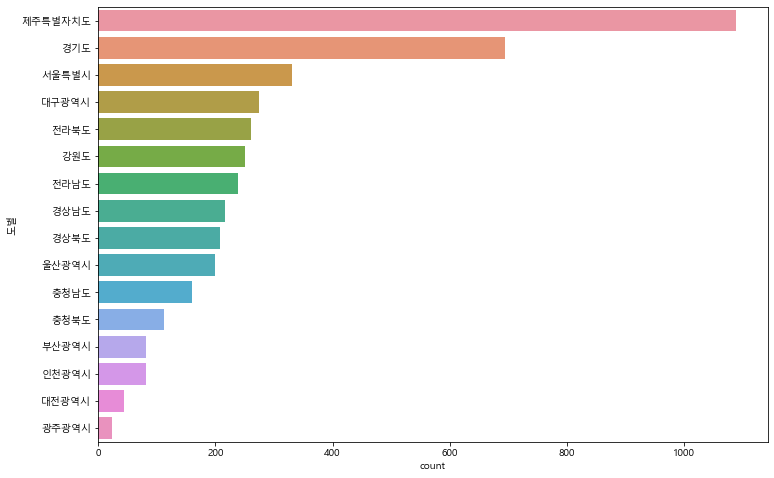

In [34]:
#전기차 충전소 도별 개수
plt.figure(figsize=(12,8))
sns.countplot(data = el1, y = '도별', order=el1['도별'].value_counts(sort=True, ascending=False).index)
plt.show()
# x,y 는 x축으로 할건지 y축으로 할건지 지정